<a href="https://colab.research.google.com/github/tonijhanel/LLM-Engineering/blob/main/AIAgentFunctions_Gradi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Agent Functions and Gradio UI

## Installs and Imports

In [ ]:
!pip install python-dotenv
!pip install openai
!pip install gradio

In [3]:
# imports
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
from google.colab import userdata


## Connect to OPEN AI API

In [5]:
openai_api_key = userdata.get('OPENAI_API_KEY')
if openai_api_key:
    print("OpenAI API Key exists")
else:
    print("OpenAI API Key not set")

MODEL = "gpt-4o-mini"
openai = OpenAI(api_key=openai_api_key)

OpenAI API Key exists


In [6]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

## Define Ticket Price Tool

In [7]:
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [8]:
get_ticket_price("London")

Tool get_ticket_price called for London


'$799'

In [9]:
# Define price_function structure

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [12]:
# define tools

tools = [{"type": "function", "function": price_function}]

In [37]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

## Add Image Generation

In [38]:
import base64
from io import BytesIO
from PIL import Image

def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

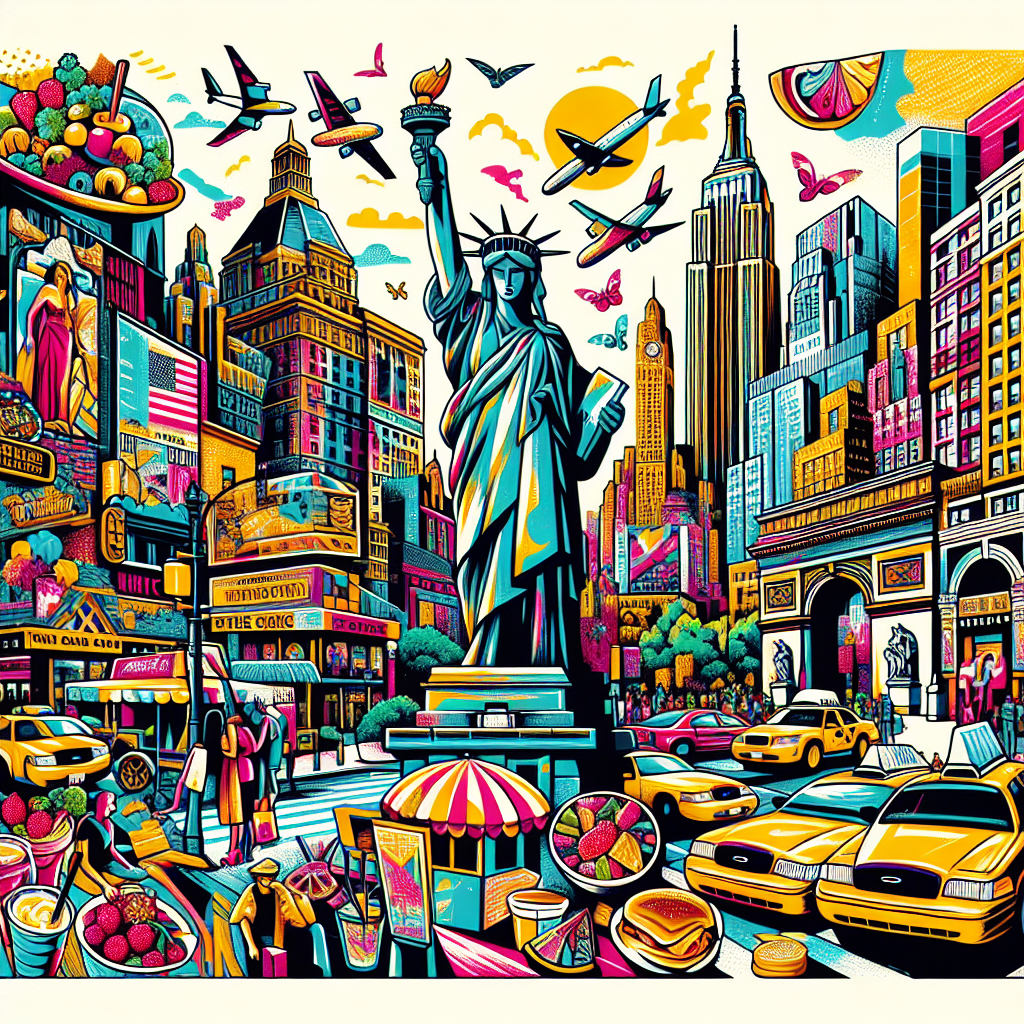

In [39]:
image = artist("New York City")
display(image)

## Add Audio Features

In [61]:
from pydub import AudioSegment
from pydub.playback import play
from io import BytesIO
from IPython.display import Audio

def talker(message, voice):
    response = openai.audio.speech.create(
        model="tts-1",
        voice=voice,
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Auto Play the generated audio
    #display(Audio(output_filename, autoplay=True))

    # for colab implementation
    return output_filename

In [60]:
talker("Well, hi there", "nova")

'output_audio.mp3'

## Define Chat Functionality

In [62]:

def chat(history, voice_selection):
    """
    Processes user chat input, interacts with the OpenAI model, handles tool calls,
    and generates an audio response.

    Args:
        history (list): A list of message dictionaries representing the conversation history.
        voice_selection (str): The voice to use for the audio response.

    Returns:
        tuple: A tuple containing the updated history and any generated image (or None).
    """
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)

    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    #talker(reply, voice_selection)

    # for colab implemenation
    audio_file_path = talker(reply, voice_selection)
    return history, image, audio_file_path

## Create Gradio UI

In [63]:
from gradio import themes

with gr.Blocks(theme=themes.Monochrome()) as ui:

    gr.Markdown("# My Awesome AI Assistant")

    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        with gr.Column(scale=2):
            with gr.Row():
                entry = gr.Textbox(
                    placeholder="Chat with our AI Assistant:",
                    label="Chat with our AI Assistant:",
                    scale=2,
                    container=False)

                submit_button = gr.Button(
                    value="➤",
                    variant="primary",
                    scale=0,
                    elem_classes=["submit-button"]
                )
        with gr.Column(scale=0):
            voice_dropdown = gr.Dropdown(
            choices=[("Alloy", "alloy"), ("Echo", "echo"), ("Fable", "fable"), ("Onyx","onyx"), ("Nova", "nova"), ("Shimmer", "shimmer")],
            label="Select Voice",
            value="alloy",
            scale=1)

    with gr.Row():
       audio_output = gr.Audio(label="AI Voice Response", autoplay=True)

    with gr.Row():
        clear = gr.Button("Clear")


    def do_entry(message, history, voice_selection):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot, voice_dropdown], outputs=[entry, chatbot]).then(
        chat, inputs=[chatbot, voice_dropdown], outputs=[chatbot, image_output, audio_output ]
    )

    submit_button.click(do_entry, inputs=[entry, chatbot, voice_dropdown], outputs=[entry, chatbot]).then(
        chat, inputs=[chatbot, voice_dropdown], outputs=[chatbot, image_output, audio_output ]
    )


    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a4ff0b272ed0f6b9dd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
